### Text Mining
- 비정형 텍스트 데이터에서 의미를 추출하는 작업
- 자연어 처리 기술을 접목해서 최근에는 많이 진행되고 있음
  - 자연어 처리 : 사람의 언어를 컴퓨터가 이해할 수 있도록 연구하는 학문


### 텍스트마이닝 프로세스

- 텍스트 마이닝 분석 프로세스

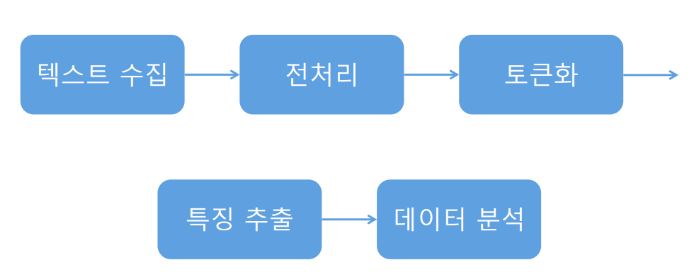

### 1. 단어 빈도 분석
- 워드 카운드 : 단어의 빈도를 측정하여 분석

#### 데이터 수집 및 로딩

- https://github.com/smilegate-ai/korean_unsmile_dataset
- 스마일게이트의 한국어 혐오표현 데이터 셋 활용

In [ ]:
# 현재 작업 디렉토리 및 폴더 확인
import os
print(os.getcwd())
print(os.listdir(os.getcwd()))

/content
['.config', 'mecab-ko-dic-2.1.1-20180720.tar.gz', 'drive', 'mecab-0.996-ko-0.9.2.tar.gz', 'mecab-ko-dic-2.1.1-20180720', 'mecab-0.996-ko-0.9.2', 'sample_data']


In [ ]:
# 작업 디렉토리 변경
%cd "./drive/MyDrive/Colab Notebooks/텍스트마이닝"

/content/drive/MyDrive/Colab Notebooks/텍스트마이닝


In [ ]:
print(os.getcwd())
print(os.listdir(os.getcwd()))

/content/drive/MyDrive/Colab Notebooks/텍스트마이닝
['ex01_텍스트마이닝_기초.ipynb', 'ex00_허깅페이스.ipynb', 'data', 'Mecab-ko-for-Google-Colab']


In [ ]:
import pandas as pd

In [ ]:
# 훈련용 데이터, 평가용 데이터 로딩
train = pd.read_csv("./data/unsmile_train_v1.0.tsv", delimiter="\t")
test = pd.read_csv("./data/unsmile_valid_v1.0.tsv", delimiter="\t")

In [ ]:
display(train.head())
display(test.head())

In [ ]:
# 결측치 확인
display(train.isnull().info())
display(test.isnull().info())

#### 특정 혐오표현에서 많이 사용되는 단어를 확인하고 시각화

In [ ]:
text_train = train[train["악플/욕설"] == 1]["문장"]  # 특정 혐오표현 텍스트가 들어 있는 문장열 추출
text_train

In [ ]:
# 띄어쓰기 중심으로 토큰화 : nltk 패키지 활용
from nltk import word_tokenize
import nltk
nltk.download("punkt")

In [ ]:
words = word_tokenize(list(text_train.values)[0])
words

In [ ]:
# 띄어쓰기 중심으로 토큰화 : python code 활용
badword_tokens = [t for doc in text_train for t in doc.split(" ")]

In [ ]:
badword_tokens

In [ ]:
# 단어의 빈도 세기
from collections import Counter

In [ ]:
counter = Counter(badword_tokens)  # 같은 단어들의 갯수 세기

In [ ]:
counter.most_common(40)

In [ ]:
# 워드클라우드를 위한 한글폰트 설치
!apt-get install -y fonts-nanum*
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
!pip install wordcloud

In [ ]:
from wordcloud import WordCloud

In [ ]:
# 객체 생성
wc = WordCloud(background_color="white",  # 배경색 설정
               random_state=715,  # 난수 seed 고정
               font_path="/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")

In [ ]:
input_str = " ".join(badword_tokens)  # 쪼개진 토큰들을 하나의 문자열로 병합

In [ ]:
wc_rs = wc.generate_from_text(input_str)  # 문자열로부터 워드클라우드 생성

In [ ]:
# matplotlib을 이용한 시각화
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')  # 다운받은 폰트를 maplotlib의 폰트로 설정

In [ ]:
from PIL import Image, ImageFilter
wc_image = wc_rs.to_image()
blurred_image = wc_image.filter(ImageFilter.GaussianBlur(radius=7))  # 블러처리

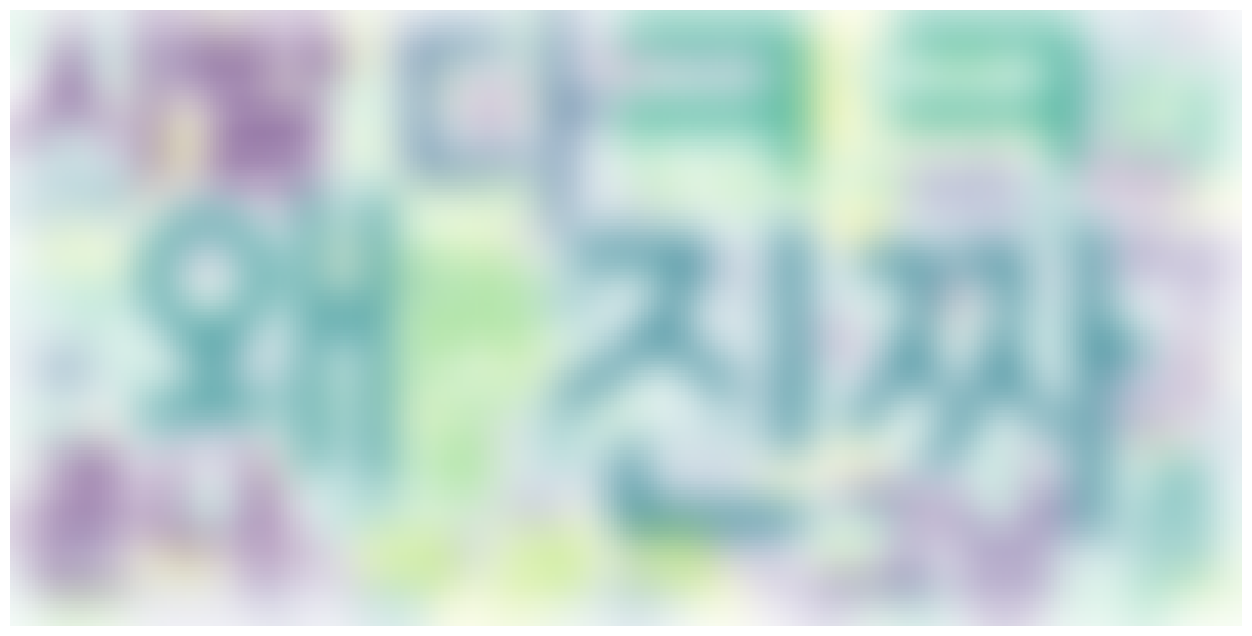

In [ ]:
plt.figure(figsize=(20, 8))  # 그림을 그리는 그림판 셋팅
plt.imshow(blurred_image)  # 그림을 보여줘라
plt.axis('off')  # 눈금X
plt.show()

### 2. 감성분석

#### 데이터 전처리
- ㅋㅋㅋㅋ, ㅎㅎㅎ 같은 정해진 횟수 없이 반복되는 글자 삭제
- 한 글자 단어 삭제(의미 부여가 어려운 단어라고 가정)

#### 정규표현식(Regular Expression)
- 특정한 패턴(규칙)을 가진 문자열의 집합을 표현하는 언어
- 핸드폰 번호나 이메일처럼 패턴이 있는 문자열의 검색과 치환을 위해 프로그래밍 언어에서 대부분 지원하고 있다
- https://wikidocs.net/21703

In [ ]:
import re # 정규표현식 사용 모듈 로딩

In [ ]:
# 전화번호 검출 예시
p = re.compile("010-?[0-9]{4}-?\\d{4}")

In [ ]:
p.search("전화번호 : 010-1234-5678")

<re.Match object; span=(7, 20), match='010-1234-5678'>

In [ ]:
p.search("010-010-010")

#### 혐오표현 데이터 클렌징

In [ ]:
from tqdm import tqdm  # 반복 횟수를 시각화하고 예상 시간을 계산

In [ ]:
# 패턴생성
p = re.compile("[ㅋㅎㄷㅇ~!?.\\-ㅡ0-9a-z]+")
train_clean = [] # 전처리된 전체 텍스트를 담을 리스트
for doc in tqdm(train['문장']) : # 약 1만 5천 번 반복
  temp = [] # 전처리된 문장의 토큰들이 들어갈 리스트
  for token in doc.split(" ") : # 한개의 문장을 토큰화하여 반복
    if len(token) < 2 : # 1글자 제거
      continue
    if p.search(token) : # 정규표현식 패턴에 매칭되는지 확인
      continue
    temp.append(token)
  train_clean.append(" ".join(temp)) # 정상적인 토큰을 전체리스트에 추가


100%|██████████| 15005/15005 [00:00<00:00, 77116.76it/s]


In [ ]:
# 패턴생성
p = re.compile("[ㅋㅎㄷㅇ~!?.\\-ㅡ0-9a-z]+")
test_clean = [] # 전처리된 전체 텍스트를 담을 리스트
for doc in tqdm(test['문장']) : # 약 1만 5천 번 반복
  temp = [] # 전처리된 문장의 토큰들이 들어갈 리스트
  for token in doc.split(" ") : # 한개의 문장을 토큰화하여 반복
    if len(token) < 2 : # 1글자 제거
      continue
    if p.search(token) : # 정규표현식 패턴에 매칭되는지 확인
      continue
    temp.append(token)
  test_clean.append(" ".join(temp)) # 정상적인 토큰을 전체리스트에 추가


100%|██████████| 3737/3737 [00:00<00:00, 104048.07it/s]


#### 정규표현식 re 모듈을 이용한 교체

In [ ]:
# 반복글자 패턴 검출 및 교체
re.sub("[ㅋㅎㄷㅇ~!?.-ㅡ0-9a-z]+", "", "ㅋㅋㅋㅋㅋㅋㅋ안녕!!!!")

'안녕'

In [ ]:
# 한 글자 패턴 검출 및 교체
re.sub(" \\w ", "", " 안 녕하세요!!!")

'녕하세요!!!'

#### 형태소 분석
- Konlpy : https://konlpy.org/ko/latest/index.html
- Kiwi : https://github.com/bab2min/kiwipiepy
- PORORO : https://github.com/kakaobrain/pororo

##### konlpy

In [ ]:
!pip install konlpy

In [ ]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

In [ ]:
%cd Mecab-ko-for-Google-Colab

In [ ]:
!bash install_mecab-ko_on_colab_light_220429.sh

In [ ]:
from konlpy.tag import Okt, Kkma, Mecab

In [ ]:
okt = Okt()  # 트위터 기반으로 시작된 형태소 분석기 비교적 신조어에 강한 편
kkma = Kkma() # 속도는 느리지만, 품사태깅이 디테일하다
mecab = Mecab() # 처리 속도가 빠르다

In [ ]:
# 형태소로 분리
okt.morphs("아버지가 방에 들어가신다.")

['아버지', '가', '방', '에', '들어가신다', '.']

In [ ]:
# 형태소 분리 후 품사 부착
okt.pos("어제는 저녁을 맛있게 먹었다.")

[('어제', 'Noun'),
 ('는', 'Josa'),
 ('저녁', 'Noun'),
 ('을', 'Josa'),
 ('맛있게', 'Adjective'),
 ('먹었다', 'Verb'),
 ('.', 'Punctuation')]

In [ ]:
okt.tagset

{'Adjective': '형용사',
 'Adverb': '부사',
 'Alpha': '알파벳',
 'Conjunction': '접속사',
 'Determiner': '관형사',
 'Eomi': '어미',
 'Exclamation': '감탄사',
 'Foreign': '외국어, 한자 및 기타기호',
 'Hashtag': '트위터 해쉬태그',
 'Josa': '조사',
 'KoreanParticle': '(ex: ㅋㅋ)',
 'Noun': '명사',
 'Number': '숫자',
 'PreEomi': '선어말어미',
 'Punctuation': '구두점',
 'ScreenName': '트위터 아이디',
 'Suffix': '접미사',
 'Unknown': '미등록어',
 'Verb': '동사'}

In [ ]:
# 토큰 정규화, 어근 추출
okt.pos("어제는 저녁을 맛있게 먹었닼ㅋㅋㅋㅋㅋ", norm=True, stem=True)

[('어제', 'Noun'),
 ('는', 'Josa'),
 ('저녁', 'Noun'),
 ('을', 'Josa'),
 ('맛있다', 'Adjective'),
 ('먹다', 'Verb'),
 ('ㅋㅋㅋ', 'KoreanParticle')]

In [ ]:
# 명사 추출
kkma.nouns("아버지 가방에 들어가신다.")

['아버지', '가방']

In [ ]:
kkma.tagset  # 심화 분석

In [ ]:
# kkma -> 느리다
# 클렌징한 데이터를 형태소 단위로 분리
konlpy_morphs_tmp = []  # 형태소로 분리된 전체 데이터가 들어갈 리스트
for doc in tqdm(train_clean):  # 1만 5천번 반복
  rs = kkma.morphs(doc)  # 형태소로 분리
  konlpy_morphs_tmp.append(" ".join(rs))  # 리스트에 추가

In [ ]:
# test 데이터
# 클렌징한 데이터를 형태소 단위로 분리
konlpy_morphs_train = []  # 형태소로 분리된 전체 데이터가 들어갈 리스트
for doc in tqdm(train_clean):  # 1만 5천번 반복
  rs = mecab.morphs(doc)  # 형태소로 분리
  konlpy_morphs_train.append(" ".join(rs))  # 리스트에 추가

100%|██████████| 15005/15005 [00:01<00:00, 11610.15it/s]


In [ ]:
# train 데이터
konlpy_morphs_test = []
for doc in tqdm(test_clean):
  rs = mecab.morphs(doc)
  konlpy_morphs_test.append(" ".join(rs))

100%|██████████| 3737/3737 [00:00<00:00, 10354.54it/s]


In [ ]:
konlpy_morphs_train

##### Kiwi

In [ ]:
!pip install kiwipiepy

In [ ]:
from kiwipiepy import Kiwi
kiwi = Kiwi()

In [ ]:
kiwi.tokenize("아버지 가방에 들어가신다.")

[Token(form='아버지', tag='NNG', start=0, len=3),
 Token(form='가방', tag='NNG', start=4, len=2),
 Token(form='에', tag='JKB', start=6, len=1),
 Token(form='들어가', tag='VV', start=8, len=3),
 Token(form='시', tag='EP', start=11, len=1),
 Token(form='ᆫ다', tag='EF', start=11, len=2),
 Token(form='.', tag='SF', start=13, len=1)]

#### 불용어 처리(stop word)
- 분석 시 필요 없는, 의미가 없는 토큰들을 제거하는 행위

In [ ]:
from kiwipiepy.utils import Stopwords
stopwords = Stopwords()  # 객체생성
kiwi.tokenize("분석 결과에서 불용어만 제외하고 출력할 수도 있다.", stopwords=stopwords)

[Token(form='분석', tag='NNG', start=0, len=2),
 Token(form='결과', tag='NNG', start=3, len=2),
 Token(form='불', tag='NNG', start=8, len=1),
 Token(form='용어', tag='NNG', start=9, len=2),
 Token(form='제외', tag='NNG', start=13, len=2),
 Token(form='출력', tag='NNG', start=18, len=2),
 Token(form='있', tag='VA', start=25, len=1)]

In [ ]:
stopwords.add(("결과", "NNG"))  # 새로운 불용어 등록

In [ ]:
kiwi.tokenize("분석 결과에서 불용어만 제외하고 출력할 수도 있다.", stopwords=stopwords)

[Token(form='분석', tag='NNG', start=0, len=2),
 Token(form='불', tag='NNG', start=8, len=1),
 Token(form='용어', tag='NNG', start=9, len=2),
 Token(form='제외', tag='NNG', start=13, len=2),
 Token(form='출력', tag='NNG', start=18, len=2),
 Token(form='있', tag='VA', start=25, len=1)]

#### 띄어쓰기 교정
- https://bab2min.github.io/kiwipiepy/v0.15.0/kr/#kiwipiepy.Kiwi.space

In [ ]:
kiwi.space("띄어쓰기없이작성된텍스트네이걸교정 해")

'띄어쓰기 없이 작성된 텍스트네 이걸 교정해'

#### 이모지 제거

In [ ]:
!pip install emoji

In [ ]:
import emoji

In [ ]:
emoji.replace_emoji(":) 하하하하 재밌다 !!! 😀")

':) 하하하하 재밌다 !!! '

### 3. 토큰화 및 수치화
- 토큰화 : 일정 단위로 텍스트를 분리하는 작업
  - 단어(띄어쓰기)
  - 글자(char)
  - n-gram(유니, 바이, 트라이 등)
  - 기타(형태소, 품사 등)
- 수치화(특성 추출) : 의미있는 정보를 담고 있는 숫자 형태로 변환하는 방법, 데이터를 정형화하는 효과가 있다
  - 라벨인코딩
  - BOW
  - Tf-idf
  - Word embedding

##### BOW(Bag Of Word)
- 문장에서 특정 단어의 등장 빈도를 수치화하는 방법
- 특징
  - 문장에서 단어의 순서를 고려하지 않는다(문맥x)
  - 말뭉치에서 사용되는 단어가 많으면 부피가 비례해서 커진다
- 단점 : 희소한 데이터의 형태가 나올 수 있다(너무 부피가 커질 수 있다) -> <U>Word embedding</U> 활용

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
sample_text = ["나는 오늘 저녁에 치킨을 먹을꺼야",
               "너는 오늘 저녁에 무엇을 먹을꺼니?",
               "나는 오늘 아침에 운동을 하고 왔어",
               "어제 저녁에 운동을 했더니 배가 많이 고프다"]

In [ ]:
# step 1 : 단어사전 구축
sample_cv = CountVectorizer()
sample_cv.fit(sample_text)


CountVectorizer()

In [ ]:
# 단어사전 확인
sample_cv.vocabulary_

{'나는': 1,
 '오늘': 10,
 '저녁에': 13,
 '치킨을': 14,
 '먹을꺼야': 5,
 '너는': 2,
 '무엇을': 6,
 '먹을꺼니': 4,
 '아침에': 8,
 '운동을': 12,
 '하고': 15,
 '왔어': 11,
 '어제': 9,
 '했더니': 16,
 '배가': 7,
 '많이': 3,
 '고프다': 0}

In [ ]:
# step 2 : 단어사전을 기반으로 각 문장에서 단어의 빈도를 세어 표현
result = sample_cv.transform(sample_text)

In [ ]:
result.toarray()

array([[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0],
       [1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]])

In [ ]:
# 단어사전을 데이터프레임으로 변환
result_df = pd.DataFrame([sample_cv.vocabulary_.keys()],
                         columns = sample_cv.vocabulary_.values())
result_df = result_df.sort_index(axis=1)  # 컬럼을 기준으로 정렬
result_df

In [ ]:
pd.concat([result_df, pd.DataFrame(result.toarray())])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,고프다,나는,너는,많이,먹을꺼니,먹을꺼야,무엇을,배가,아침에,어제,오늘,왔어,운동을,저녁에,치킨을,하고,했더니
0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0
1,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,1,0,1,1,1,0,0,1,0
3,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1


##### Tf-idf
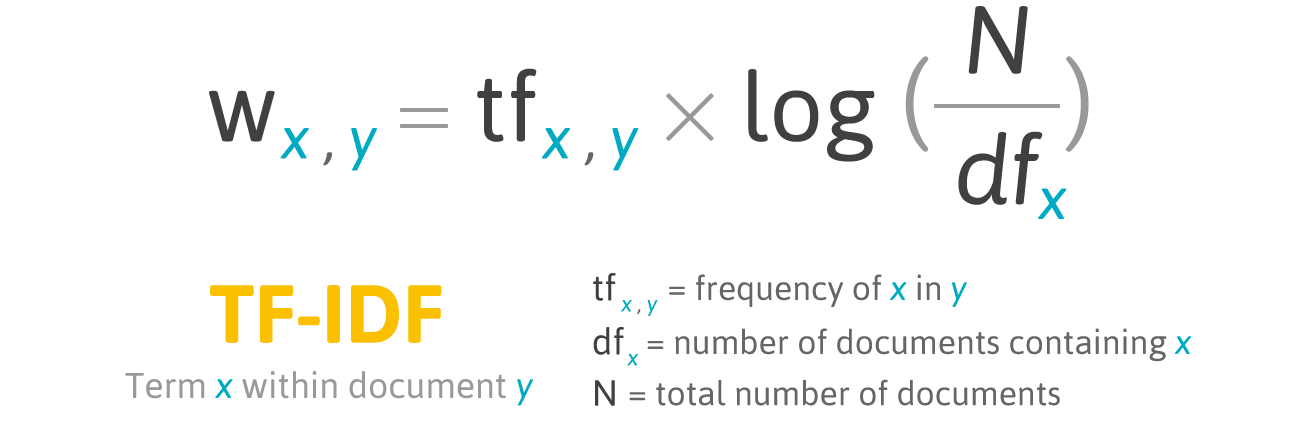

- 말뭉치(corpus) : 텍스트마이닝,자연어처리 분야에서 학습을 위해 사용하는 데이터셋
- 문서(document) : 말뭉치에서 각 샘플을 치징하는 단어
- TF(Term Frequency) : 하나의 문서(document)에서 개별 단어들이 등장하는 빈도 수 -> 높을 수록 좋다
- DF(Document Frequency) : 하나의 단어(토큰)가 전체 말뭉치에서 등장하는 문서(document) 수

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
sample_tf_idf = TfidfVectorizer()
sample_tf_idf.fit(sample_text)

TfidfVectorizer()

In [ ]:
len(sample_tf_idf.vocabulary_)  # 단어사전 구축

17

In [ ]:
sample_tf_idf.transform(sample_text).toarray()  # tf-idf 방식으로 수치화

array([[0.        , 0.42530476, 0.        , 0.        , 0.        ,
        0.53944516, 0.        , 0.        , 0.        , 0.        ,
        0.34432086, 0.        , 0.        , 0.34432086, 0.53944516,
        0.        , 0.        ],
       [0.        , 0.        , 0.51199172, 0.        , 0.51199172,
        0.        , 0.51199172, 0.        , 0.        , 0.        ,
        0.32679768, 0.        , 0.        , 0.32679768, 0.        ,
        0.        , 0.        ],
       [0.        , 0.36559366, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.46370919, 0.        ,
        0.29597957, 0.46370919, 0.36559366, 0.        , 0.        ,
        0.46370919, 0.        ],
       [0.40726515, 0.        , 0.        , 0.40726515, 0.        ,
        0.        , 0.        , 0.40726515, 0.        , 0.40726515,
        0.        , 0.        , 0.32109252, 0.25995207, 0.        ,
        0.        , 0.40726515]])

#### word embedding
- 인공지능 학습 기반
- 장점
  - 밀집된 공간(특정 크기)에 표현되게 한다
  - 훨씬 압축된 단어의 의미를 내포하는 숫자가 도출


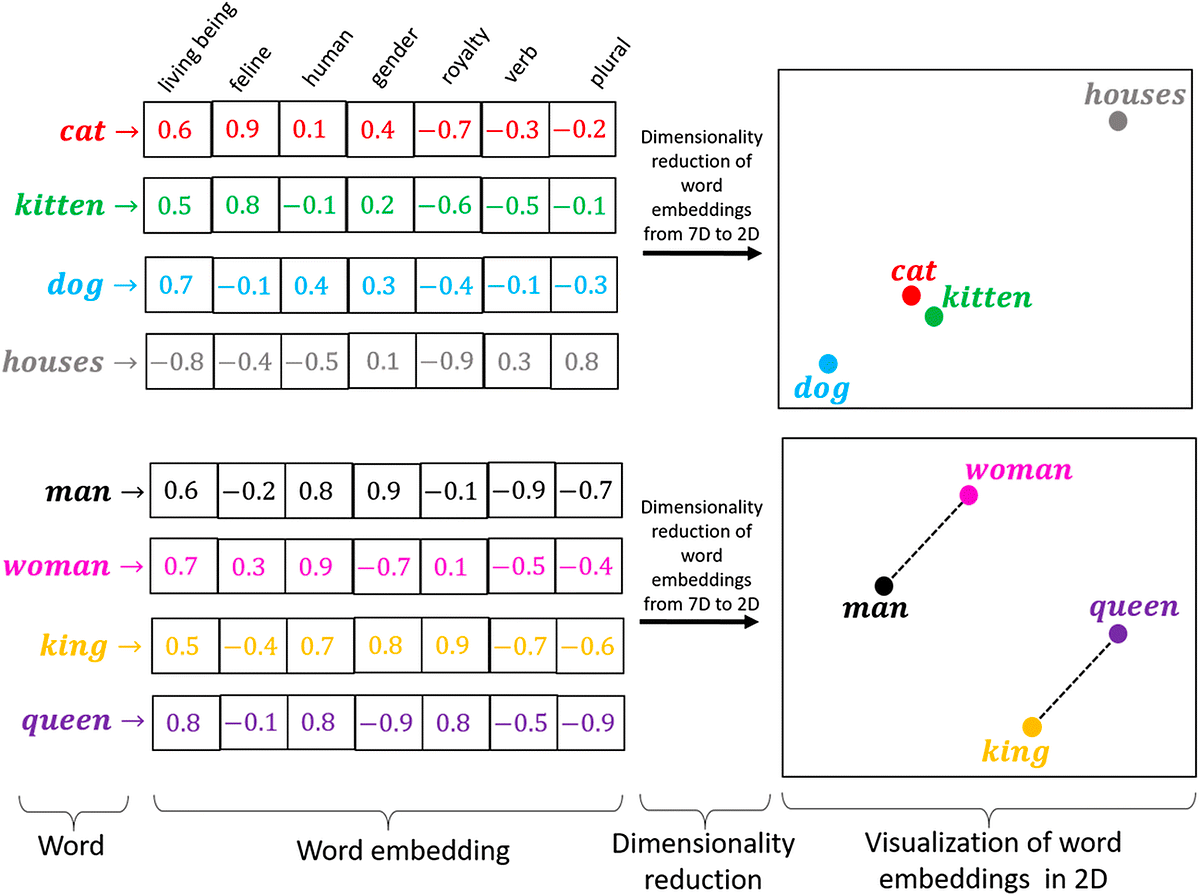

In [ ]:
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [ ]:
embedding = model.encode(sample_text)

In [ ]:
embedding.shape

(4, 384)